# random change in erodibility by fire

In [1]:
# here are the new functionalities to implement randomly burned areas....

class ErodibilityStepper:
    """
    This class is initialized by a decay_constant, describing the rate at which
    the erodibility of burned areas recovers, and a baseline erodibility value Ksed0.
    """
    def __init__(self, decay_time=1, K_sed0=1):
        self.decay_time = decay_time
        self.K_sed0 = K_sed0
        
    def stepper(self, space, dt):
        """
        This method takes in  a space object "space",
        an equilibrium (in the absence of burning) erodibility Ksed0,
        and a timestep "space_dt" to modify the erodibility
        of `space` on each gridcell by one timestep by the equation
        dK/dt = -decay_const*(Ksed-Ksed0). 
        Describing a decay of the erodibility toward its equilibrium
        value Ksed_0
        """
        # solve the DE with simple Euler method
        dK_sed =  -(space.K_sed-K_sed0)*dt/self.decay_time # erodibility decay in time
        space.K_sed += dK_sed # modify the erodibility in place
        
class Burner:
    """
    This is initialized by a fire frequency, mean fire radius in units of the grid size,
    and the amount K_sed_boost by which the sediment erodibility is increased by fire.
    The method `fire` modifies (in place) the erodibility of nodes where the fire occurred.
    """
    def __init__(self, fire_freq=1, R_fire_mean=1, K_sed_boost=1, dt = 1):
        """
        fire frequency -- how often fires occur [1/T]
        fire radius -- typical size of fires [L]
        K_sed_boost -- amount by which K_sed is increased by fire
        dt -- space model timestep.
        """
        self.fire_freq = fire_freq # average number of fires per unit time
        self.R_fire_mean = R_fire_mean # the radius of the fire... 
        self.K_sed_boost = K_sed_boost # the amount by which the sediment erodibility is increased by fire
        self.dt = dt # the timestep on which to evaluate the probability that a fire occurs
        
    @property
    def R_fire(self):
        """
        choose a random fire size from an exponential distribution
        having mean size R_fire_mean
        """
        return np.random.exponential(self.R_fire_mean) # exponential random var
        
        
    def fire(self, space, grid):
        """
        Generates a fire at a random location within the grid.
        First calculates whether or not a fire occurs at the timestep.
        Then 
        """
        # fire occurs if..
        #    a random exceeds the probability that fire does not occur
        occurs = np.exp(-self.dt*self.fire_freq) < np.random.random() # prob fire does not occur < random 
        if not occurs: # if fire does not occur...
            pass # do nothing. This comes first as it's the most common scenario.
        else: # if fire does occur
            K_sed = space.K_sed # get the array of sediment erodibilities before the fire
            # find the coordinates of this erodibility array which are to be changed
            center = np.random.choice(K_sed.size) # select a random node for the fire center
            # locate all nodes within R_fire of the center node.
            changed_nodes = self._within(center, space, grid) # based on Laurent's code.
            # modify those nodes only.. they should increase erodibility !
            K_sed[changed_nodes]+= self.K_sed_boost # increase them by K_sed_boost
            # set these into the space object as the new erodibility
            space.K_sed = K_sed # modify in place. Erodibility is now boosted by the fire.
            # This occurs on all cells within proximity R_fire of the fire center
            
            # just a print block to explain what's happening...
            s1 = grid.x_of_node[center]
            s2 = grid.y_of_node[center]
            s3 = len(changed_nodes)
            print('fire at ({},{}) with {} nodes inflamed'.format(s1,s2,s3))
        
    def _within(self,center, space, grid):
        """
        return all nodes within distance R_fire of center within grid. Utility function.
        Takes:
            center -- a single index (i.e. '3') into the 1D array of nodes
            R_fire -- the radius of a fire in gridsize units
            space -- the SPACE object (called ha..)
            grid -- the RasterModelGrid object (called mg ..)
        """
        centerPoint = (grid.x_of_node[center], grid.y_of_node[center]) # the center of the fire
        mask = grid.calc_distances_of_nodes_to_point(centerPoint) < self.R_fire # mask of nodes in radius
        # all nodes within R_fire of the centerPoint
        return np.arange(mask.size)[mask] # return indices of all nodes within distance R_fire

/home/kpierce/anaconda/envs/espin/lib/python3.9/site-packages/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("pink").copy()
  cmap.set_bad(color=color_for_closed)
/home/kpierce/anaconda/envs/espin/lib/python3.9/site-packages/landlab/plot/imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


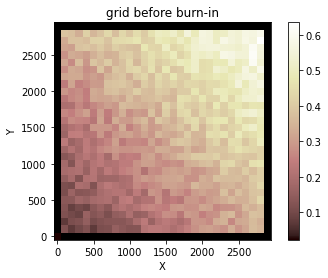

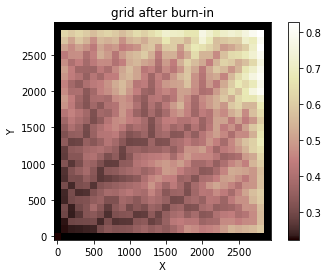

-- 0 years -- 0.1 seconds --
-- 1000 years -- 2.4 seconds --
fire at (1000.0,1400.0) with 1 nodes inflamed


KeyboardInterrupt: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from landlab.components import (DepressionFinderAndRouter,
                                FastscapeEroder,
                                FlowAccumulator,
                                Space)
from landlab import (RasterModelGrid,
                     imshow_grid)
%matplotlib inline
import time

dt = 50 # timestep in years
runtime = 100000 # length of the simulation in years
dx = 100 # size of a cell in ...m ? 
np.random.seed(5000) # reproducible yet random

# 5x5 grid with baselevel in lower left corner
# all other boundary nodes closed
# init topography is plane tilted up to the upper right with noise

mg = RasterModelGrid((30, 30), xy_spacing=dx) # 3km x 3km 
_ = mg.add_zeros('topographic__elevation', at='node')
mg.at_node['topographic__elevation'] += (mg.node_y / 10000. + 
                                         mg.node_x / 10000. + np.random.rand(len(mg.node_y)) / 10.) # sloped up
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,
                                        left_is_closed=True,
                                        right_is_closed=True,
                                        top_is_closed=True)
mg.set_watershed_boundary_condition_outlet_id(
     0, mg.at_node['topographic__elevation'], -9999.)

# show the pre-burn-in grid
mg.imshow('node','topographic__elevation')
plt.title('grid before burn-in')
plt.show()

#Instantiate Fastscape eroder, flow router, and depression finder
fr = FlowAccumulator(mg, flow_director='D8')
df = DepressionFinderAndRouter(mg)
fsc = FastscapeEroder(
    mg,
    K_sp=.001,
    m_sp=.5,
    n_sp=1)

# burn in an initial drainage ntework using the fastscape eroder
for it in range(100):
    fr.run_one_step()
    df.map_depressions()
    fsc.run_one_step(dt=dt)
    mg.at_node['topographic__elevation'][0] -= 0.003 # Uplift
    
    
# add soil to the drainage network
_ = mg.add_zeros('soil__depth', at='node', dtype=float) 
mg.at_node['soil__depth'] += 0.5
mg.at_node['topographic__elevation'] += mg.at_node['soil__depth']


# plot after burn-in grid
mg.imshow('node','topographic__elevation')
plt.title('grid after burn-in')
plt.show()


# init the space component
K_sed0 = 0.00001 # the baseline soil erodiblity
K_sed = np.ones(mg.shape)*K_sed0 # the initial soil erodibility per node
ha = Space(
    mg,
    K_sed=K_sed,
    K_br=1e-10,
    F_f=0.5,
    phi=0.1,
    H_star=1.,
    v_s=0.001,
    m_sp=0.5,
    n_sp = 1.0,
    sp_crit_sed=0,
    sp_crit_br=0)


# init the erodibility stepper
decay_time = 100*dt # time it takes the erodibility perturbution to decay
es = ErodibilityStepper(decay_time=decay_time, K_sed0=K_sed0)
# this leads to decay in the erodibility from whatever value it's at.

# init the burner
burner = Burner(fire_freq=1/(dt*50),
                R_fire_mean=5*dx,
                K_sed_boost=5*K_sed0,
                dt=dt)
# this produces fires whick kick up the erodibility...


start_time = time.time()
for it in range(runtime//dt):
    fr.run_one_step() # accumulate the flow
    df.map_depressions() # find landscape depressions (which do not erode)
    ha.run_one_step(dt=dt) # step the transport model
    es.stepper(ha,dt=dt) # decay the erodibility back to baseline from the former timestep
    burner.fire(ha,mg) # light any fires (increase erodibility)
    mg.at_node['bedrock__elevation'][0] -= 2e-6*dt # add in the uplift
    if it*dt % 1000 == 0:
        print("--", it*dt, "years -- %s seconds --" % round((time.time() - start_time), 1))
        
# plot after iteration grid
mg.imshow('node','topographic__elevation')
plt.title('grid after timesteppin')
plt.show()

#Show sediment flux map
fig = plt.figure()
plot = plt.subplot()
imshow_grid(mg, 'sediment__flux', plot_name='Sediment flux', var_name = 'Sediment flux', var_units=r'm$^3$/yr', grid_units=('m', 'm'), cmap='Blues')
plt.show()



# slope-area plot
area = mg.at_node['drainage_area'][mg.core_nodes]
slope = mg.at_node['topographic__steepest_slope'][mg.core_nodes]

fig = plt.figure()
slope_area_plot = plt.subplot()
slope_area_plot.set_xscale('log')
slope_area_plot.set_yscale('log')
plt.scatter(area, slope)
plt.show()


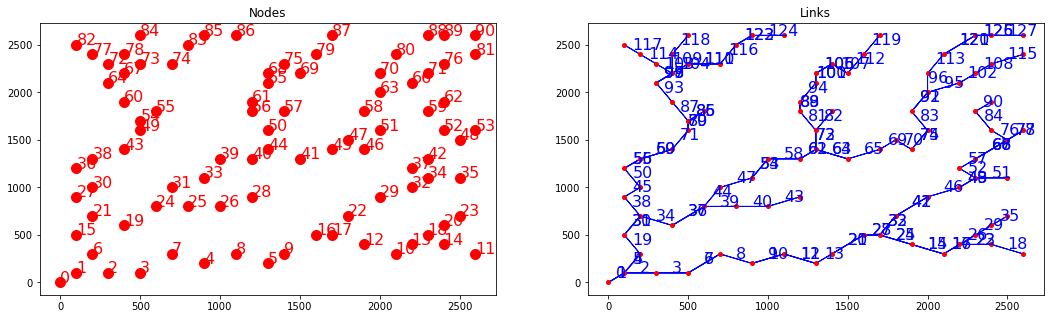

In [6]:
from create_network import create_network_from_raster
nmg = create_network_from_raster(
    mg,
    method='constant',
    #n_widths=20,
    # node_spacing=30,
    d_node_spacing=2*dx,
    min_channel_thresh=30000,
    fields=['drainage_area', 'topographic__elevation'])

from landlab.plot import graph

## Plot nodes
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
graph.plot_nodes(nmg)
plt.title("Nodes")

## Plot nodes + links
plt.subplot(1,2,2)
graph.plot_nodes(nmg,with_id=False,markersize=4)
graph.plot_links(nmg)
plt.title("Links")
plt.show()